In [10]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import f_oneway
import numpy as np
import seaborn as sns
from sklearn.model_selection import \
     (LeaveOneOut,
      KFold)
from numpy.random import seed

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

import dill as pickle

# Loading the data 

In [11]:
device_test_data = pd.read_csv("test.csv")
device_train_data = pd.read_csv("train.csv")

device_train_copy = device_train_data.copy()
device_test_copy = device_test_data.copy()
device_train_copy.head()



,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,...,20.0,756.0,2549.0,9.0,7.0,19,0,0,1,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,...,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0,2
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0,2
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0,2
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0,1


# Data Cleaning

In [12]:
# Check for correlation
# Compute the correlation matrix
corr_matrix = device_train_copy.corr()

# Set the correlation threshold
threshold = 0.5

# Find pairs of predictors with correlation above the threshold
correlated_pairs = {}
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            correlated_pairs[(corr_matrix.columns[i], corr_matrix.columns[j])] = corr_matrix.iloc[i, j]

# Display the correlated pairs
print("Predictor pairs with correlation above", threshold, ":")
for pair, correlation in correlated_pairs.items():
    print(pair, "- Correlation:", correlation)

Predictor pairs with correlation above 0.5 :
('fc', 'pc') - Correlation: 0.644616313823049
('four_g', 'three_g') - Correlation: 0.5841704347797088
('px_height', 'px_width') - Correlation: 0.510054785070389
('ram', 'price_range') - Correlation: 0.9171186800614674
('sc_h', 'sc_w') - Correlation: 0.5061942995120674


##### As shown:
##### 1. The front and Primary cameras are correlated as usually these features are related.
##### 2. 4G and 3G are correlated as normally the mobile that have 4G also have 3G , also the majority have 3G so the 3G predictor is not effecient.
##### 3. pixel resolution height and width are correlated as they are made with the same technology so usually both have the same level of resolution.
##### 4. Screen height and width are correlated as the normal case that they are directly proportional.


In [13]:
# Split the data to X and Y , X = Predictors Y = Response 
# Drop the correlated predictors
device_train_copy = device_train_copy.dropna()  # To drop any NA cells if present
device_test_copy = device_test_copy.dropna()  # To drop any NA cells if present

X_test_data = device_test_copy.drop(['three_g','fc','px_height','px_width','sc_h','sc_w'], axis=1)
X_test_data['px_total'] = device_test_copy['px_height'] * device_test_copy['px_width']

X_test_data['sc_diagonal'] = np.sqrt(np.square(device_test_copy['sc_h']) + np.square(device_test_copy['sc_w']))

X = device_train_copy.drop(['price_range','three_g','fc','px_height','px_width','sc_h','sc_w'], axis=1)
# Combine resolution height and width in one predictor
X['px_total'] = device_train_copy['px_height'] * device_train_copy['px_width']

# Combine the screen height with screen width in one predictor (Screen diagonal) 
X['sc_diagonal'] = np.sqrt(np.square(device_train_copy['sc_h']) + np.square(device_train_copy['sc_w']))

# Y = response which is the price range
Y = device_train_copy['price_range']


In [14]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test_data)


In [15]:
# Split the data to test and train data randomly
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, stratify=Y)


In [16]:
# Save the data to csv file
data = pd.DataFrame(X_test, columns=X.columns)
test = pd.DataFrame(X_test_data, columns=X_test_data.columns)

data['price_range'] = y_test.values
data.to_csv('Cleaned_test.csv', index=False)
test.to_csv('Cleaned_APP_test.csv', index=False)


## Function to calulate sensitivity and specificity

In [17]:
# Define a function to calculate sensitivity and specificity for each class from a confusion matrix:


def calculate_metrics_per_class(confusion_matrix):
    """
    Calculate sensitivity and specificity for each class from a confusion matrix.

    Parameters:
    - confusion_matrix: numpy array, shape (n_classes, n_classes)
        The confusion matrix.

    Returns:
    - sensitivities: numpy array, shape (n_classes,)
        Sensitivity (True Positive Rate or Recall) for each class.
    - specificities: numpy array, shape (n_classes,)
        Specificity (True Negative Rate) for each class.
    """
    n_classes = confusion_matrix.shape[0]
    sensitivities = np.zeros(n_classes)
    specificities = np.zeros(n_classes)

    for i in range(n_classes):
        true_positive = confusion_matrix[i, i]
        false_negative = np.sum(confusion_matrix[i, :]) - true_positive
        false_positive = np.sum(confusion_matrix[:, i]) - true_positive
        true_negative = np.sum(confusion_matrix) - (true_positive + false_negative + false_positive)

        # Sensitivity (True Positive Rate or Recall) for each class
        sensitivities[i] = true_positive / (true_positive + false_negative)

        # Specificity (True Negative Rate) for each class
        specificities[i] = true_negative / (true_negative + false_positive)

    return sensitivities, specificities

# Fitting the Data to the Model

## 1. KNN 


##### Get the best value for the K by iterating 

In [18]:
# Define a range of k values
k_values = range(1, 9)

# Initialize lists to store metrics for each k
accuracies = []
sensitivities_list = []
specificities_list = []

# Iterate through different k values
for k in k_values:
    # Define the KNN model with current k value
    knn_model = KNeighborsClassifier(n_neighbors=k)

    # Fit the model and create the confusion matrix
    knn_model.fit(X_train, y_train)
    knn_model_pred = knn_model.predict(X_test)

    # Calculate confusion matrix
    confusion_mat = cm(knn_model_pred, y_test)

    # Calculate metrics per class
    sensitivities, specificities = calculate_metrics_per_class(confusion_mat)

    # Calculate the accuracy
    accuracy=np.trace(confusion_mat)/np.sum(confusion_mat)

    # Append metrics to lists
    accuracies.append(accuracy)
    sensitivities_list.append(sensitivities)
    specificities_list.append(specificities)

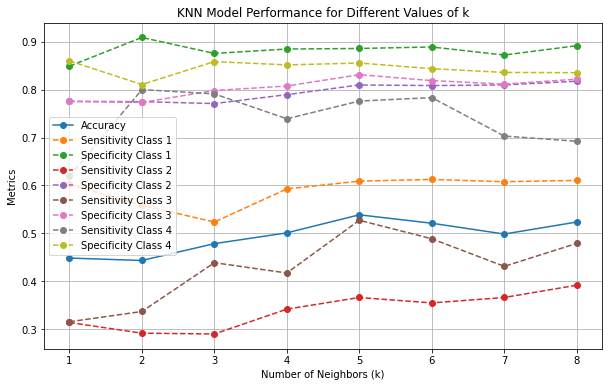

In [19]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(k_values, accuracies, label='Accuracy', marker='o')

# Plot sensitivity and specificity for each class
for i in range(len(sensitivities)):
    plt.plot(k_values, [sensitivities_list[j][i] for j in range(len(k_values))],
             label=f'Sensitivity Class {i + 1}', linestyle='--', marker='o')
    plt.plot(k_values, [specificities_list[j][i] for j in range(len(k_values))],
             label=f'Specificity Class {i + 1}', linestyle='--', marker='o')

# Add labels and legend to the plot
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Metrics")
plt.title("KNN Model Performance for Different Values of k")
plt.legend()
plt.grid(True)
plt.show()

#### The selected model

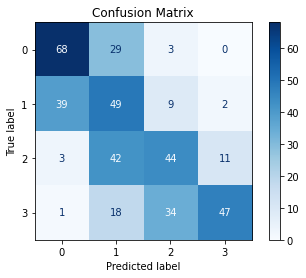

In [20]:
# Define the KNN model: 
knn_model = KNeighborsClassifier(n_neighbors=6)
# Fit the model and create the confusion matrix:
knn_model.fit(X_train, y_train)
knn_model_pred = knn_model.predict(X_test)

conf_matrix=cm(knn_model_pred, y_test)

# Plot confusion matrix
plot_confusion_matrix(knn_model, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Calculate metrics per class
sensitivities, specificities = calculate_metrics_per_class(conf_matrix)

# Print or use the metrics per class
for i in range(len(sensitivities)):
    print(f"Class {i + 1}: Sensitivity = {sensitivities[i]}, Specificity = {specificities[i]}")

# Calculate the accuracy: 
accuracy=np.trace(conf_matrix)/np.sum(conf_matrix)
print(accuracy)

Class 1: Sensitivity = 0.6126126126126126, Specificity = 0.8888888888888888
Class 2: Sensitivity = 0.35507246376811596, Specificity = 0.8084291187739464
Class 3: Sensitivity = 0.4888888888888889, Specificity = 0.8187702265372169
Class 4: Sensitivity = 0.7833333333333333, Specificity = 0.8436578171091446
0.5213032581453634


# 2. QDA Model

In [22]:
# Prepare and fit QDA model:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [23]:
# dumb the model using pickle
filename = 'QDA_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(qda, file)

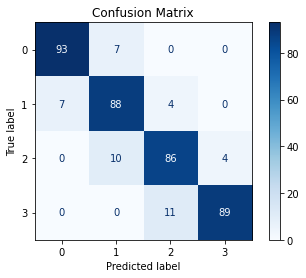

In [24]:
# Making predictions with the fitted model and generating the confusion matrix: 
qda_pred = qda.predict(X_test)
conf_QDA_mat = cm(qda_pred, y_test)

# Plot confusion matrix
plot_confusion_matrix(qda, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Calculate metrics per class
confusion_matrix=cm(qda_pred, y_test)
sensitivities, specificities = calculate_metrics_per_class(confusion_matrix)

# Print or use the metrics per class
for i in range(len(sensitivities)):
    print(f"Class {i + 1}: Sensitivity = {sensitivities[i]}, Specificity = {specificities[i]}")

# Calculate the accuracy: 
accuracy=np.trace(confusion_matrix)/np.sum(confusion_matrix)
print("The accuracy is: ", accuracy)

Class 1: Sensitivity = 0.93, Specificity = 0.9765886287625418
Class 2: Sensitivity = 0.8380952380952381, Specificity = 0.9625850340136054
Class 3: Sensitivity = 0.8514851485148515, Specificity = 0.9530201342281879
Class 4: Sensitivity = 0.956989247311828, Specificity = 0.9640522875816994
The accuracy is:  0.8922305764411027


### As shown in the confusion matrix and sensitivity specificity, accuracy values that the model was able to predict 89% , and the sensitivity of the 2nd and 3rd class are lower than the other classes, so the model have a problem with the medium and high costs. The training error can dramatically underestimate the test error. A cross validation used to select the appropriate level of flexibility for the fitted model, approaching more realistic test error.


# K-Fold for cross validating test error

In [26]:
# Define the number of folds (K)
num_folds = 5
# Reset index of 'Y' array
Y.reset_index(drop=True, inplace=True)
# Create KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)

# Lists to store metrics across folds
accuracies = []
sensitivities_list = []
specificities_list = []
iteration_accuracies=[]
iteration_sensitivities=[]
iteration_specificities=[]

In [27]:
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit the model and create the confusion matrix
    qda = QDA(store_covariance=True)
    qda.fit(X_train, y_train)
    qda_pred = qda.predict(X_test)

    # Calculate metrics per class
    confusion_mat = cm(qda_pred, y_test)
        
    # Calculate metrics per class
    sensitivities, specificities = calculate_metrics_per_class(confusion_mat)

    # Calculate the accuracy
    accuracy=np.trace(confusion_mat)/np.sum(confusion_mat)
        
    # Append metrics to the iteration lists
    iteration_accuracies.append(accuracy)
    iteration_sensitivities.append(sensitivities)
    iteration_specificities.append(specificities)

# Append metrics to the lists
accuracies.append(np.mean(iteration_accuracies))
sensitivities_list.append(np.mean(iteration_sensitivities, axis=0))
specificities_list.append(np.mean(iteration_specificities, axis=0))


In [28]:
print(accuracies)
print(sensitivities_list)
print(specificities_list)

[0.9050666868175463]
[array([0.93451609, 0.88234817, 0.87569268, 0.9290569 ])]
[array([0.98123751, 0.96061408, 0.9559706 , 0.97581967])]


### The accuracy when using K-folds is very close to the previous test error.

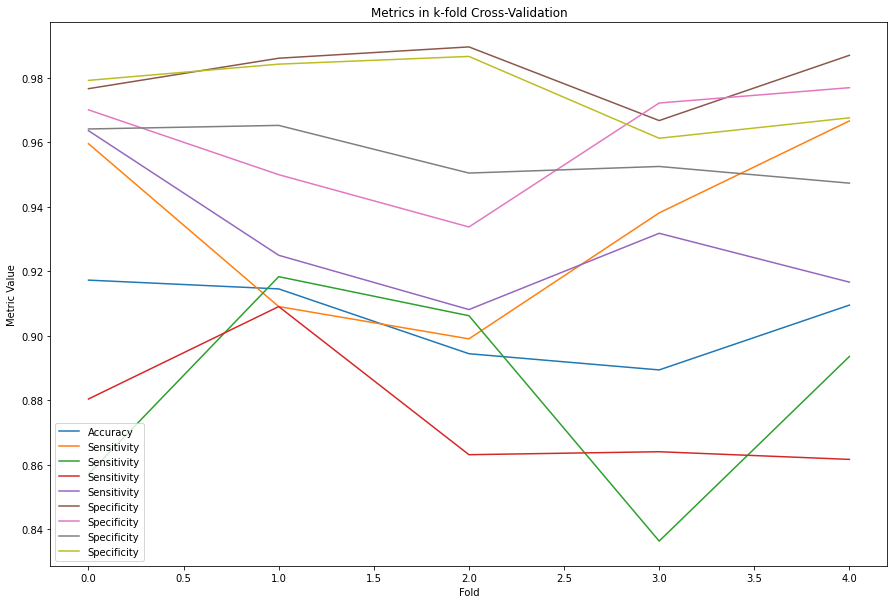

In [29]:
# Plot the results
plt.figure(figsize=(15, 10))
plt.plot(range(num_folds), iteration_accuracies, label='Accuracy')
plt.plot(range(num_folds), iteration_sensitivities, label='Sensitivity')
plt.plot(range(num_folds), iteration_specificities, label='Specificity')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.title('Metrics in k-fold Cross-Validation')
plt.legend()
plt.show()

# 3. ANN

In [30]:
# Convert the integer-encoded labels to one-hot encoded vectors
y_train_categorical = to_categorical(y_train)
# Split the train data to validation
X_est, X_val, y_est, y_val = train_test_split(X_train, y_train_categorical, test_size = 0.25, random_state = 0, stratify=y_train_categorical)


### Building the network

In [31]:
# Define model
ANN_model = Sequential()
ANN_model.add(Dense(80, kernel_regularizer=regularizers.L1L2(1e-3,1e-3), activation='relu', kernel_initializer='he_normal', input_shape=(X.shape[1],)))
ANN_model.add(Dense(40, kernel_regularizer=regularizers.L1L2(1e-3,1e-3), activation='relu', kernel_initializer='he_normal'))
ANN_model.add(Dense(16, kernel_regularizer=regularizers.L1L2(1e-3,1e-3), activation='relu', kernel_initializer='he_normal'))

# Output layer for multiclass classification
ANN_model.add(Dense(y_train_categorical.shape[1], kernel_regularizer=regularizers.L1L2(1e-3,1e-3), activation='softmax'))

# print the network and its layers 
ANN_model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                1360      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                656       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 5,324
Trainable params: 5,324
Non-trainable params: 0
_________________________________________________________________


#### Using a 3 hidden layer network with dense 40,20,16 each with activation function RelU. The kernel initializer is chosen to be he_normal as it preferred when using RelU activation function as it works good.
#### Regularization is used to prevent overfitting and improve the generalization ability of models. The L1 and L2 are used as regulizers, as L1 Regularization (Lasso) adds a penalty term proportional to the absolute value of the coefficients, while L2 Regularization (Ridge) adds a penalty term proportional to the square of the coefficients.
#### Softmax is the activation function for the output layer as the network works as a classifier.Softmax is an exponential function that generates normalized activations so thatthey sum up to 1. They can beinterpreted as class-membership probabilities.

### Compile the network

In [32]:
# compile the model
ANN_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0007), metrics=['accuracy'])


#### By using Adam optimizer, Fast convergence, Robust to noisy gradients, Adaptive to different neural network architectures.

In [33]:
# define early stopping strategy 
es = EarlyStopping(monitor='val_loss',min_delta=0.005, restore_best_weights=True, patience=70, verbose=1)

#### Chosing a patience = 70 training will continue until there have been 70 consecutive epochs with no improvement in the monitored metric.

In [34]:
# fit model
history = ANN_model.fit(X_est, y_est,epochs=400, batch_size=99, validation_data=(X_val, y_val), callbacks=es)

Epoch 1/400
13/13 [==============================] - 1s 15ms/step - loss: 2.6673 - accuracy: 0.2940 - val_loss: 2.5965 - val_accuracy: 0.3283
Epoch 2/400
13/13 [==============================] - 0s 2ms/step - loss: 2.5302 - accuracy: 0.3685 - val_loss: 2.5110 - val_accuracy: 0.3885
Epoch 3/400
13/13 [==============================] - 0s 2ms/step - loss: 2.4330 - accuracy: 0.4422 - val_loss: 2.4295 - val_accuracy: 0.4386
Epoch 4/400
13/13 [==============================] - 0s 2ms/step - loss: 2.3451 - accuracy: 0.4933 - val_loss: 2.3448 - val_accuracy: 0.5013
Epoch 5/400
13/13 [==============================] - 0s 2ms/step - loss: 2.2510 - accuracy: 0.5410 - val_loss: 2.2542 - val_accuracy: 0.5539
Epoch 6/400
13/13 [==============================] - 0s 2ms/step - loss: 2.1558 - accuracy: 0.5913 - val_loss: 2.1611 - val_accuracy: 0.5689
Epoch 7/400
13/13 [==============================] - 0s 2ms/step - loss: 2.0653 - accuracy: 0.6315 - val_loss: 2.0709 - val_accuracy: 0.5990
Epoch 8/400


In [35]:
# Save the model
ANN_model.save('ANN_model')

INFO:tensorflow:Assets written to: ANN_model\assets


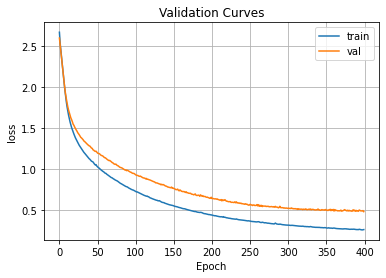

In [36]:
# plot validation curve
plt.figure()
plt.title('Validation Curves')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

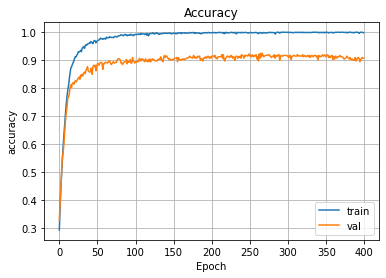

In [37]:
plt.figure()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.grid()
plt.show()

### Test the network

In [38]:
y_pred = np.argmax(ANN_model.predict(X_test), axis=1)  # Get the max value of the classes probability of the output layer

confusion_matrix=cm(y_pred, y_test)
sensitivities, specificities = calculate_metrics_per_class(confusion_matrix)

# Print or use the metrics per class
for i in range(len(sensitivities)):
    print(f"Class {i + 1}: Sensitivity = {sensitivities[i]}, Specificity = {specificities[i]}")

# Calculate the accuracy: 
accuracy=np.trace(confusion_matrix)/np.sum(confusion_matrix)
print("The accuracy is: ", accuracy)

Class 1: Sensitivity = 0.9340659340659341, Specificity = 0.9804560260586319
Class 2: Sensitivity = 0.8777777777777778, Specificity = 0.961038961038961
Class 3: Sensitivity = 0.898989898989899, Specificity = 0.9732441471571907
Class 4: Sensitivity = 0.9745762711864406, Specificity = 0.9857142857142858
The accuracy is:  0.9246231155778895


# Models Comparison

In [39]:
# Define functions to calculate performance metrics
def calculate_performance_metrics(y_true, y_pred):
    # Calculate confusion matrix
    confusion_m = cm(y_true, y_pred)
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')
    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return confusion_m, accuracy, precision, recall, f1

# Collect predictions and true labels for each model
y_pred_knn = knn_model.predict(X_test)
y_pred_qda = qda.predict(X_test)
y_pred_ann = np.argmax(ANN_model.predict(X_test), axis=1)
y_true = y_test

# Calculate performance metrics for each model
cm_knn, accuracy_knn, precision_knn, recall_knn, f1_knn = calculate_performance_metrics(y_true, y_pred_knn)
cm_qda, accuracy_qda, precision_qda, recall_qda, f1_qda = calculate_performance_metrics(y_true, y_pred_qda)
cm_ann, accuracy_ann, precision_ann, recall_ann, f1_ann = calculate_performance_metrics(y_true, y_pred_ann)

# Compare models using ANOVA test
f_statistic, p_value = f_oneway([accuracy_knn, precision_knn, recall_knn, f1_knn],
                                [accuracy_qda, precision_qda, recall_qda, f1_qda],
                                [accuracy_ann, precision_ann, recall_ann, f1_ann])

# Print results
print("KNN Classifier:")
print("Confusion Matrix:")
print(cm_knn)
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1 Score:", f1_knn)
print()

print("QDA Classifier:")
print("Confusion Matrix:")
print(cm_qda)
print("Accuracy:", accuracy_qda)
print("Precision:", precision_qda)
print("Recall:", recall_qda)
print("F1 Score:", f1_qda)
print()

print("ANN Classifier:")
print("Confusion Matrix:")
print(cm_ann)
print("Accuracy:", accuracy_ann)
print("Precision:", precision_ann)
print("Recall:", recall_ann)
print("F1 Score:", f1_ann)
print()

print("ANOVA Test:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

KNN Classifier:
Confusion Matrix:
[[71 17  3  0]
 [23 56 12  0]
 [ 5 33 51  8]
 [ 0 10 29 80]]
Accuracy: 0.6482412060301508
Precision: 0.6770079475822346
Recall: 0.6482412060301508
F1 Score: 0.6551737879902947

QDA Classifier:
Confusion Matrix:
[[ 87   4   0   0]
 [  3  84   4   0]
 [  0   6  81  10]
 [  0   0   9 110]]
Accuracy: 0.9095477386934674
Precision: 0.9094328023094194
Recall: 0.9095477386934674
F1 Score: 0.909373118301856

ANN Classifier:
Confusion Matrix:
[[ 85   6   0   0]
 [  6  79   6   0]
 [  0   5  89   3]
 [  0   0   4 115]]
Accuracy: 0.9246231155778895
Precision: 0.9247597342989559
Recall: 0.9246231155778895
F1 Score: 0.9246571178155835

ANOVA Test:
F-statistic: 1459.0037093907138
p-value: 4.9566024600455244e-12


### The ANOVA test produces two main outputs:

#### F-statistic: The F-statistic measures the ratio of variation between group means to the variation within the groups. A larger F-statistic indicates greater differences between group means relative to the variations within each group.
#### p-value: The p-value indicates the probability of observing the observed F-statistic if the null hypothesis were true. In the context of ANOVA, the null hypothesis is that all group means are equal (there are no significant differences between the groups). The extremely small value of p-value indicates strong evidence against the null hypothesis. Therefore, you would conclude that there are significant differences in the performance metrics among the models.


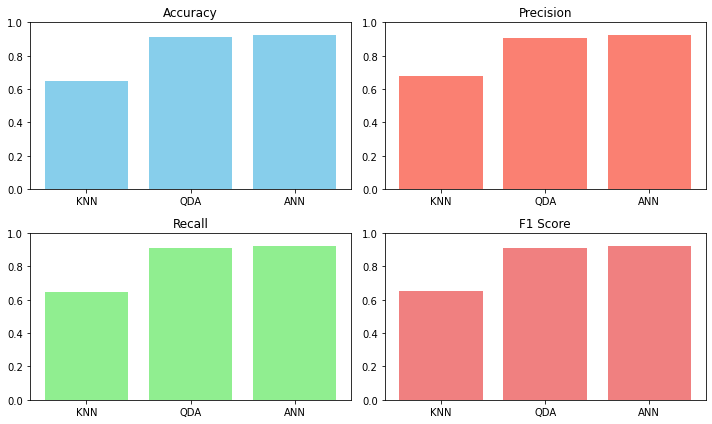

In [40]:
# Define model names
model_names = ['KNN', 'QDA', 'ANN']

# Define performance metrics
accuracy = [accuracy_knn, accuracy_qda, accuracy_ann]
precision = [precision_knn, precision_qda, precision_ann]
recall = [recall_knn, recall_qda, recall_ann]
f1 = [f1_knn, f1_qda, f1_ann]

# Create bar plots for each performance metric
plt.figure(figsize=(10, 6))

# Accuracy
plt.subplot(2, 2, 1)
plt.bar(model_names, accuracy, color='skyblue')
plt.title('Accuracy')
plt.ylim(0, 1)

# Precision
plt.subplot(2, 2, 2)
plt.bar(model_names, precision, color='salmon')
plt.title('Precision')
plt.ylim(0, 1)

# Recall
plt.subplot(2, 2, 3)
plt.bar(model_names, recall, color='lightgreen')
plt.title('Recall')
plt.ylim(0, 1)

# F1 Score
plt.subplot(2, 2, 4)
plt.bar(model_names, f1, color='lightcoral')
plt.title('F1 Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

### 1. Precision: measures the accuracy of positive predictions made by the model, specifically the ratio of true positive predictions to all positive predictions.
#### Precision = True Positives / (True Positives + False Positives)
### 2. Recall (Sensitivity): measures the ability of the model to correctly identify all positive instances, specifically the ratio of true positive predictions to all actual positive instances.
#### Recall = True Positives / (True Positives + False Negatives)
### 3. The F1 Score: is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. F1 Score reaches its best value at 1 (perfect precision and recall) and worst at 0. 
#### F1 Score = 2 * (Precision * Recall) / (Precision + Recall) 
### Accuracy: measures the overall correctness of the model's predictions across all classes. It calculates the ratio of correctly predicted instances (both true positives and true negatives) to the total number of instances in the dataset.

# Results: 
## As illustrated, based on these metrics, the ANN (Artificial Neural Network) Classifier appears to perform the best among the three models. It achieves the highest accuracy, precision, recall, and F1 Score. The ANN model's superior performance indicates that it is better at correctly classifying instances across all classes, with fewer false positives and false negatives compared to the other models, although the QDA model have a good performance which is close to  the ANN model.